# Практическое задание №7. Детектирование объектов

1. Сделайте краткий обзор любой статьи посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

2. Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

3. (не обязательное) Ссылка на репозиторий с полным кодом для обучения ssd нейросети - https://github.com/sergeyveneckiy/ssd-tensorflow. Попробуйте улучшить точность ее работы и напишите отчет, что вы пробовали изменить в ее параметрах и как это отражалось на процессе обучения нейронной сети. Обратите внимание! Мин. сист. требования для запуска данного проекта - это минимум 8 Gb ОЗУ. Если у вас недостаточно мощности компьютера, то вы можете просто изучить содержимое исходного кода и датасета данного проекта

## 1. Обзор статьи по MS COCO dataset

>Оригинальная научная статья по MS COCO dataset - [https://arxiv.org/pdf/1405.0312.pdf]()

Microsoft Common Objects in Context(сокращеннаяCOCOНабор данных - это набор данных, предоставленный Microsoft, который может использоваться для в работах:
- распознавание изображений,
- сегментация,
- аннотирование,
- другие.

Основные характеристики этого набора данных следующие:

1. Object segmentation
2. Recognition in Context
3. Multiple objects per image
4. More than 300,000 images
5. More than 2 Million instances
6. 80 object categories
7. 5 captions per image
8. Keypoints on 100,000 people

 Набор данных использует распознавание объектов в качестве цели, в основном сложных ежедневных сцен.
 Цели на изображении точно калибруются. Изображение включает в себя:
 - 91 класс,
 - 328000 изображений,
 - 2500000 меток.

## 2. Запуск детектора для анализа машин на стоянке

### Импорт библиотек

In [20]:
# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
# %tensorflow_version can likely be used after 2.0rc0
#!pip install tf-nightly-gpu-2.0-preview
#!pip install tf-nightly-gpu-2.0-preview
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow

import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: 


### Формирование и обработка результатов детектирования**

> Запишем основные функции из примера TensorFlow (https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb) и адаптируем их для своих целей



>Все, что ниже до ****************************  относится к визуализации результат работы детектора

In [64]:
# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(10, 5))
  plt.grid(False)
  plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpeg")
  response = urlopen(url)
  image_data = response.read()
  #read image
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  #print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=2,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, class_name='Car', max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score and class_name == class_names[i].decode("ascii"):
    # if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Возвращаем рамки для объектов

In [55]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
  I_shape=np.uint8(image).shape
  #print(I_shape)
  im_array=[]
  for i in range(min(boxes.shape[0], max_boxes)): 
    #print(tuple(boxes[i]))
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])


      yminI = np.int(ymin*I_shape[0])
      ymaxI = np.int(ymax*I_shape[0])
      xminI = np.int(xmin*I_shape[1])
      xmaxI = np.int(xmax*I_shape[1])
      imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
      #print(imf.shape,imf[0,0,:])
      
      im_array.append(imf.copy())  
  return im_array

In [56]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
 
  image_pil = np.array(image)
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      
      imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
  return imf

### ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** ** **

### Загрузка детектора

In [9]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


***********************************************************

### Обработка изображения для передачи в детектор:

Формируем тензор

In [27]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

Выполняем детектор

In [57]:

def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=20)

  return image_with_boxes, result

Чтение имен кадров

In [58]:
import os, fnmatch
root_path = './'
listOfFiles = os.listdir(root_path)
pattern = '*.jpg'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]


array('./18e2999891374a475d0687ca9f989d83_1602711910.jpg', dtype='<U49')

Проверяем детектор

Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.


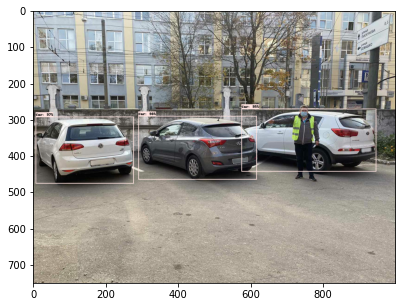

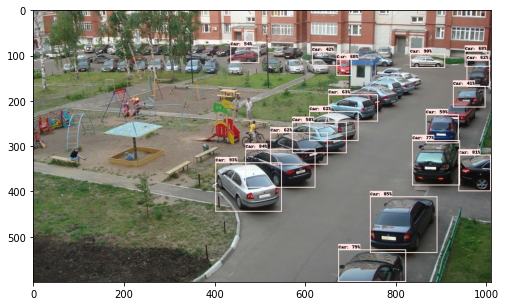

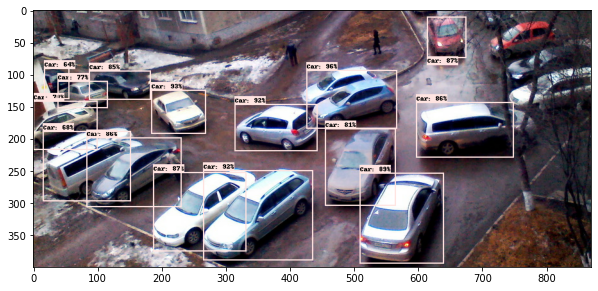

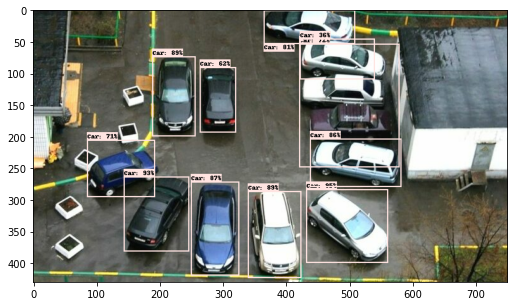

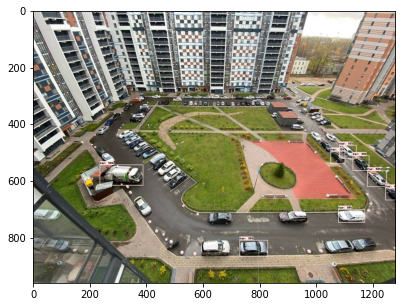

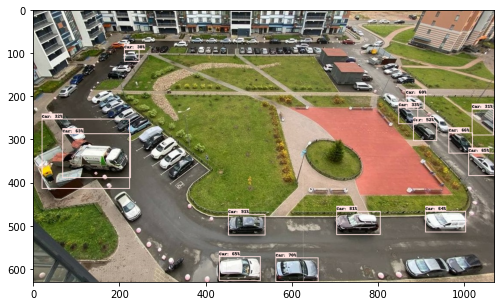

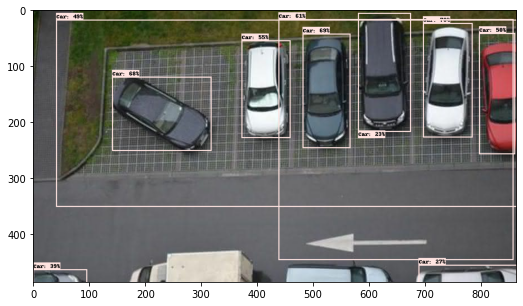

In [66]:
for name in List_name:
    image_with_boxes, result = run_detector(detector, name)
    display_image(image_with_boxes)

Что возвращает детектор:
 - detection_boxes : список из 4х (в пропорциях картинки) координат х1, у1, х2, у2 - "верхний левый" - "нижний правый" углы рамки
 - detection_class_entities - список строк с именем классов
 - detection_class_labels - список меток класса (соответствуют строкам) 

 - detection_scores - список вероятностей класса
 

In [34]:
result.keys()

dict_keys(['detection_scores', 'detection_class_labels', 'detection_boxes', 'detection_class_names', 'detection_class_entities'])

### Вывод:
> Настроил детектор ResNet на работу на локальном компьютере. Немного изменил выдачу детектора на анализ исключительно машин. Использовал в качестве исходных данных реальные изображения машин снятых из квартиры. Такой анализ использовал для применения в бизнес кейсе - поиск свободной парковки во дворе. Детектор дал приличные результаты, которые однако требуют дополнительных настроек.